# Markov Chains

In this script, we try to make a distinction between SBH and LBH. We will look at the frequency of function types and compare them between the books.

In [10]:
import glob, re, getpass, collections, operator, scipy.stats, sklearn.metrics
from itertools import chain
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from discreteMarkovChain import markovChain
from tf.fabric import Fabric

## Loading the data


See ETCBC data [here](https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html)

In [11]:
# format paths for Etienne or Cody
if getpass.getuser() == 'etien':
    locations = 'C:/Users/etien/Documents/github/bhsa/tf'
elif getpass.getuser() == 'cody':
    locations = '~/github/etcbc/bhsa/tf'

# load TF and BHSA data
TF = Fabric(locations=locations, modules='c', silent=True)
api = TF.load('''
              otype
              book chapter verse
              function domain
              typ pdp
              ''')
api.makeAvailableIn(globals()) # globalize TF methods

  0.00s loading features ...
   |     0.02s B otype                from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.01s B book                 from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.01s B chapter              from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.01s B verse                from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.07s B function             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.01s B domain               from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.19s B typ                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.13s B pdp                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.00s Feature overview: 108 for nodes; 5 for edges; 1 configs; 7 computed
  4.54s All features loaded/computed - for details use loadLog()


In [12]:
lbh_books = {'1_Chronicles', '2_Chronicles', 
             'Ezra', 'Esther', 'Nehemiah'}

sbh_books = {'Genesis', 'Exodus','Leviticus', 
             'Deuteronomy','Joshua', 'Judges', 
             '1_Kings', '2_Kings', '1_Samuel',
             '2_Samuel'}

# don't load clauses with these functions
exclude_functions = {'IntS', 'Ques', 'Exst', 'ModS',
                     'NCoS', 'NCop', 'Supp', 'PrAd',
                     'Frnt', 'Intj', 'EPPr', "ExsS", 
                     "PrcS", "Voct"}
#exclude_functions = set()
data = collections.defaultdict(list) # lbh, sbh, and individual books go in here
       
for i, clause in enumerate(F.otype.s('clause')):
    
    book, chapter, verse = T.sectionFromNode(clause)
    
    # skip clauses not in our corpora
    if book not in (lbh_books | sbh_books):
        continue
    # skip non-narrative clauses
    if F.domain.v(clause) != 'N':
        continue
        
    clause_phrases = L.d(clause, otype='phrase')
    phrase_functions = [F.function.v(phrase) for phrase in clause_phrases]
    
    # skip if clause has excluded function
    if set(phrase_functions) & exclude_functions:
        continue
        
    if book in lbh_books:
        data['lbh'].append(phrase_functions)
    elif book in sbh_books:
        data['sbh'].append(phrase_functions)
        
    data[book].append(phrase_functions)
    
print(f'Done with {i} clauses loaded in data...')

Done with 88100 clauses loaded in data...


In [13]:
unique_functions = set(F.function.v(phrase) for phrase in F.otype.s('phrase') 
                           if F.function.v(phrase) not in exclude_functions)
unique_functions = sorted(list(unique_functions))
print(unique_functions)

['Adju', 'Cmpl', 'Conj', 'Loca', 'Modi', 'Nega', 'Objc', 'PreC', 'PreO', 'PreS', 'Pred', 'PtcO', 'Rela', 'Subj', 'Time']


 # Counting frequencies phrase functions

## Phrase function count

We can count the frequency of phrase functions. We consider three different approaches to count the functions. We can: 
1) Consider all phrase functions.
2) Consider only the first phrase function of a clause.
3) Consider only the last phrase function of a clause. 
Here, we do not yet look at the sequence of words, but only the frequency of phrase functions. 

In [14]:
test = [['pred', 'subj'], ['subj','adj', 'red']]

list(chain(*test))

['pred', 'subj', 'subj', 'adj', 'red']

In [15]:
phrase_function_count = dict() # Looking at all functions
begin_phrase_function_count = dict() # Consider only the first function of a clause
end_phrase_function_count = dict() # Consider only the last function of clause 

for bookname, clauses in data.items():
    phrase_function_count[bookname] = collections.Counter(list(chain(*clauses))) 
    begin_phrase_function_count[bookname] = collections.Counter([x[0] for x in clauses]) # First function
    end_phrase_function_count[bookname] = collections.Counter([x[-1] for x in clauses]) # Last function

# Make a dataframe
df_Count = pd.DataFrame(phrase_function_count, columns=data.keys()).fillna(0)
df_Begin_Count = pd.DataFrame(begin_phrase_function_count, columns=data.keys()).fillna(0)
df_End_Count = pd.DataFrame(begin_phrase_function_count, columns=data.keys()).fillna(0)

# Normalize the dataframes. This means that we divide all frequencies by the sum of the frequencies. 
df_prob_Count = df_Count.div(df_Count.sum(axis=0), axis=1)
df_prob_Begin_Count = df_Begin_Count.div(df_Begin_Count.sum(axis=0), axis=1)
df_prob_End_Count = df_End_Count.div(df_End_Count.sum(axis=0), axis=1)

In [18]:
#Sample
df_prob_Count[list(lbh_books)] #or sbh_books

,Nehemiah,Ezra,2_Chronicles,Esther,1_Chronicles
Adju,0.035974,0.074669,0.054427,0.043700,0.062990
Cmpl,0.122912,0.102079,0.124383,0.150765,0.108207
Conj,0.219700,0.174858,0.222932,0.203933,0.216675
Loca,0.022698,0.016068,0.013208,0.008012,0.010455
Modi,0.008137,0.006616,0.005660,0.005827,0.006273
Nega,0.014561,0.006616,0.010305,0.007283,0.005227
Objc,0.075375,0.093573,0.097678,0.080845,0.085468
PreC,0.091221,0.125709,0.061393,0.061180,0.108468
PreO,0.017131,0.008507,0.020464,0.013110,0.015159
PreS,0.001713,0.001890,0.004790,0.002913,0.001045


In [21]:
df_prob_Count[list(sbh_books)]

,Joshua,2_Kings,2_Samuel,1_Samuel,Judges,1_Kings,Deuteronomy,Genesis,Exodus,Leviticus
Adju,0.026285,0.025276,0.018989,0.011253,0.016912,0.027991,0.037156,0.016512,0.032909,0.018967
Cmpl,0.152179,0.134416,0.138372,0.133383,0.146875,0.123292,0.140935,0.121257,0.109109,0.162276
Conj,0.224349,0.244895,0.256063,0.260015,0.253860,0.228924,0.214606,0.253457,0.231929,0.228662
Loca,0.012682,0.013224,0.009964,0.009152,0.009926,0.012662,0.016015,0.011738,0.023702,0.008430
Modi,0.008301,0.005859,0.009400,0.007352,0.006801,0.007498,0.005766,0.008256,0.010186,0.008430
Nega,0.011298,0.012554,0.007144,0.008252,0.009191,0.009497,0.021781,0.004775,0.010774,0.001054
Objc,0.074937,0.080013,0.061102,0.062266,0.074265,0.079807,0.100577,0.090023,0.109696,0.116965
PreC,0.068250,0.040341,0.047001,0.049662,0.043750,0.067977,0.030750,0.045061,0.049951,0.024236
PreO,0.018215,0.017911,0.015980,0.015154,0.017279,0.015495,0.035874,0.010843,0.011166,0.013699
PreS,0.002997,0.003515,0.004136,0.002851,0.001838,0.002666,0.007047,0.006068,0.001763,0.003161


A second strategy to analyse clauses is looking at the length of these clauses.

## Length clauses count

In [23]:
length_count = dict()
for bookname, clauses in data.items():
    length_count[bookname]=collections.Counter([len(x) for x in clauses])
#Dataframe
df_length_count = pd.DataFrame(length_count, columns=data.keys()).fillna(0)
#Normalized
df_prob_length_count = df_length_count.div(df_length_count.sum(axis=0), axis=1)

df_prob_length_count

,sbh,Genesis,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,lbh,Esther,Ezra,Nehemiah,1_Chronicles,2_Chronicles
1,0.052134,0.046273,0.061250,0.125850,0.100791,0.055882,0.039296,0.045066,0.045564,0.055838,0.048718,0.062824,0.052874,0.117647,0.081321,0.0616,0.049354
2,0.221476,0.241304,0.200000,0.132653,0.199605,0.230882,0.201760,0.208729,0.203237,0.256853,0.229744,0.240726,0.216092,0.294118,0.279543,0.2616,0.210332
3,0.360112,0.348137,0.339375,0.234694,0.343874,0.321324,0.390029,0.371917,0.365707,0.360406,0.403077,0.354807,0.381609,0.315508,0.330368,0.3336,0.377306
4,0.284049,0.286335,0.301250,0.418367,0.256917,0.283088,0.281525,0.296490,0.302758,0.254822,0.255897,0.252493,0.239080,0.197861,0.231258,0.2600,0.267989
5,0.069043,0.066149,0.085625,0.071429,0.073123,0.083824,0.073900,0.069734,0.070144,0.057360,0.054359,0.069206,0.096552,0.064171,0.058450,0.0664,0.070111
6,0.011171,0.009938,0.009375,0.017007,0.021739,0.019118,0.012317,0.007590,0.010192,0.013198,0.007179,0.016554,0.009195,0.010695,0.015248,0.0144,0.020756
7,0.001892,0.001863,0.003125,0.000000,0.001976,0.005882,0.001173,0.000474,0.002398,0.001523,0.000513,0.003391,0.004598,0.000000,0.003812,0.0024,0.004151
8,0.000122,0.000000,0.000000,0.000000,0.001976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000513,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


# Graphing

Here, we can create graphs for analyzing the data.

## Comparing frequencies

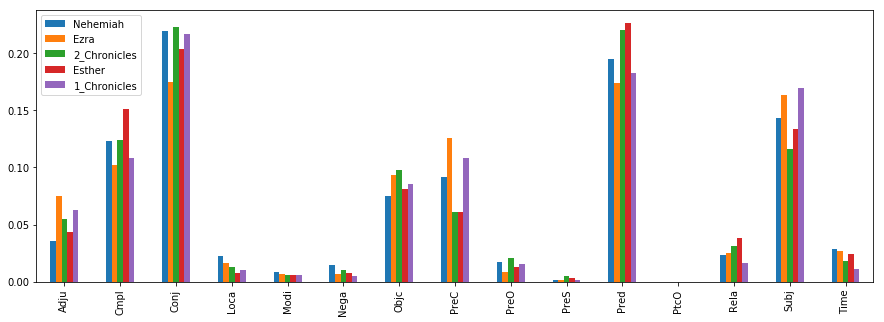

In [24]:
books = list(lbh_books) #["1_Samuel","2_Samuel"] #Choose two or more books to compare
df_graph = df_prob_Count[books] #or df_prob_Begin_Count, df_prob_length_count, df_prob_End_Count
plt.figure()
df_graph.plot(figsize = (15,5), kind='bar')
plt.show()

## Top frequent functions 

Here, a graph is made where the top most frequent functions is shown for each book. The x-axis shows the top x most frequent functions and the y-axis shows the probability that belongs to the top frequent functions. 

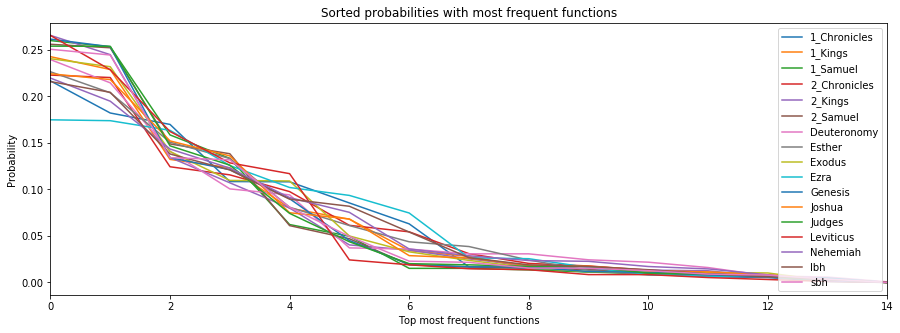

In [25]:
dictionary_prob = dict()
for column in df_prob_Count:
    probs = df_prob_Count[column].values
    dictionary_prob[column] = sorted(probs, reverse=True)
df_sorted_prob = pd.DataFrame(dictionary_prob)

plt.figure()
df_sorted_prob.plot(figsize = (15,5), kind='line')
plt.title("Sorted probabilities with most frequent functions")
plt.xlabel("Top most frequent functions")
plt.ylabel("Probability")
plt.show()

# Testing Frequencies

To compare books based on the function frequency, a chi-square test can be performed to look whether the frequencies are equivalent between books. We want to determine which books are the same and which are different. Normally, a p-value of 0.05 is used to determine whether the books are significantly different. The null hypothesis in each test is that the books are equivalent based on the chosen criteria to compare the books. If the p-value is below 0.05, we reject the null hypothesis and therefore reject the hypothesis that the books show similarity based on the criteria. 

In [102]:
def chi_squareTest(matrix):
    '''
    Perform a chi-squared test on any matrix and return the p value.
    '''
    chi2, p, dof, ex = scipy.stats.chi2_contingency(matrix)
    return p

def computetesting(df):
    '''
    Performs the chi-squared test on each pair of columns 
    to test whether two books are similar or different. 
    '''
    books = df.keys()
    df_test = pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books)
    
    # test each pair of columns
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            if indexi>indexj:
                dfTemp = df[[i,j]]                     # Select columns
                dfTemp = dfTemp[(dfTemp.T != 0).any()] # Remove zeros
                dfTemp = np.matrix(dfTemp)             # Make np matrix
                dfTemp = dfTemp.transpose()            # Transpose matrix
                dfTemp = dfTemp.astype(int)            # Convert to integers
                df_test.loc[i,j] = round(chi_squareTest(dfTemp), 5)
    return df_test.replace(0.0,np.nan)

For the dataframes: df_Count, df_Begin_Count, df_End_Count, df_length_count, the p values of the chi square testing can be obtained

In [103]:
computetesting(df_Count[list(sbh_books)])

,Joshua,2_Kings,2_Samuel,1_Samuel,Judges,1_Kings,Deuteronomy,Genesis,Exodus,Leviticus
Joshua,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_Kings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_Samuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_Samuel,NaN,NaN,0.11373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Judges,NaN,NaN,0.00116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_Kings,0.0058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Deuteronomy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genesis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exodus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Leviticus,NaN,NaN,NaN,NaN,0.00001,NaN,NaN,0.00004,NaN,NaN


In [104]:
computetesting(df_Begin_Count[list(lbh_books)])

,Nehemiah,Ezra,2_Chronicles,Esther,1_Chronicles
Nehemiah,NaN,NaN,NaN,NaN,NaN
Ezra,NaN,NaN,NaN,NaN,NaN
2_Chronicles,NaN,NaN,NaN,NaN,NaN
Esther,NaN,NaN,0.01731,NaN,NaN
1_Chronicles,NaN,NaN,NaN,NaN,NaN


# Sequence phrase functions

The frequency analysis is now completed. Now, the order of the words can be looked into. First, we create a transition frequency table where we count the number of times we go from one phrase function to the next one. The Clause Begin can be seen as the state of the sequence before starting a new clause and Clause End indicates the state of the sequence after the last phrase function. We go obviously from the Clause End to Clause begin to show that we go to new clause. 

In [129]:
df_Transition_freq = dict() # Transition matrix with frequences
df_Transition_prob = dict() # Normalized transition matrix

nodes = ["Clause_Begin", "Clause_End"] +  unique_functions

for bookname, clauses in data.items():
    transition_Matrix = np.zeros((len(nodes),len(nodes)))
    # count transitions using bigrams
    transitions = list()
    for clause in clauses:
        transitions.append("Clause_Begin")
        transitions.extend(clause)
        transitions.append("Clause_End")
    for i in range(0, len(transitions)-1):
        transition_Matrix[nodes.index(transitions[i]), nodes.index(transitions[i+1])] +=1 
    df_Trans = pd.DataFrame(transition_Matrix, columns = nodes, index = nodes)    
    
    #Remove unused transition functions
    df_Trans = df_Trans[(df_Trans.T != 0).any()]
    df_Trans = df_Trans.loc[:, (df_Trans != 0).any(axis=0)]
    
    df_Transition_freq[bookname] = df_Trans    
    #Normalized by row 
    df_Transition_prob[bookname] = df_Trans.div(df_Trans.sum(axis=1), axis=0)

#Sample
print(df_Transition_freq.keys())
df_Transition_freq["1_Samuel"] #df_Transition_prob

dict_keys(['sbh', 'Genesis', 'Exodus', 'Leviticus', 'Deuteronomy', 'Joshua', 'Judges', '1_Samuel', '2_Samuel', '1_Kings', '2_Kings', 'lbh', 'Esther', 'Ezra', 'Nehemiah', '1_Chronicles', '2_Chronicles'])


,Clause_Begin,Clause_End,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time
Clause_Begin,0.0,0.0,5.0,1.0,1732.0,0.0,2.0,2.0,4.0,41.0,21.0,18.0,155.0,87.0,39.0,1.0
Clause_End,2107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju,0.0,58.0,4.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0
Cmpl,0.0,704.0,15.0,38.0,0.0,16.0,6.0,2.0,30.0,6.0,0.0,0.0,5.0,0.0,49.0,18.0
Conj,0.0,0.0,2.0,9.0,1.0,5.0,0.0,43.0,20.0,29.0,70.0,1.0,1336.0,14.0,203.0,0.0
Loca,0.0,47.0,2.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0
Modi,0.0,32.0,1.0,6.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0
Nega,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,48.0,0.0,0.0,0.0
Objc,0.0,269.0,14.0,78.0,0.0,10.0,0.0,1.0,6.0,0.0,1.0,0.0,21.0,0.0,2.0,13.0
PreC,0.0,195.0,6.0,65.0,0.0,3.0,6.0,0.0,17.0,0.0,0.0,0.0,2.0,0.0,32.0,5.0


# Subtracting Transition Matrices

In [130]:
df_sub = df_Transition_prob["lbh"].subtract(df_Transition_prob["sbh"], fill_value =0)
round(df_sub,3)

,Clause_Begin,Clause_End,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,PtcO,Rela,Subj,Time
Clause_Begin,0.0,0.000,0.004,0.005,-0.100,0.001,-0.000,-0.003,-0.000,0.017,0.000,-0.002,0.015,-0.0,0.01,0.047,0.006
Clause_End,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.000,0.000
Adju,0.0,-0.098,0.027,0.013,0.000,0.001,-0.008,-0.001,0.039,0.003,0.001,0.000,-0.007,0.0,0.00,0.041,-0.010
Cmpl,0.0,-0.038,0.036,0.002,0.000,-0.011,-0.003,0.001,0.008,0.003,0.000,0.000,0.005,0.0,0.00,-0.007,0.006
Conj,0.0,0.000,0.022,0.011,-0.000,0.006,0.002,0.003,0.032,0.027,0.009,0.000,-0.178,0.0,0.00,0.054,0.013
Loca,0.0,-0.055,-0.007,-0.012,0.000,-0.027,0.002,-0.003,0.036,-0.011,0.005,0.000,0.084,0.0,0.00,-0.018,0.007
Modi,0.0,-0.124,0.009,0.028,0.008,-0.002,-0.002,0.001,0.032,0.030,-0.002,0.000,0.010,0.0,0.00,0.009,0.003
Nega,0.0,-0.002,0.020,0.005,0.000,0.000,0.000,0.000,0.000,0.011,0.003,0.000,-0.054,0.0,0.00,0.017,0.000
Objc,0.0,-0.010,0.050,-0.033,0.000,0.001,-0.001,0.003,-0.018,0.002,-0.000,0.000,0.016,0.0,0.00,-0.011,0.001
PreC,0.0,-0.007,0.034,-0.002,0.000,-0.016,-0.003,-0.000,0.023,0.000,0.000,0.000,-0.005,0.0,0.00,-0.019,-0.003


In [131]:
df_sub_abs = abs(df_sub)
dictionary = dict()
for index, row_dict in enumerate(df_sub_abs.to_dict(orient="records")):
    for key, value in row_dict.items():
        dictionary[nodes[index],key]=value
sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)[:10]

[(('Time', 'Clause_End'), 0.22567176590842153),
 (('Conj', 'Pred'), 0.1777348315184295),
 (('Time', 'Pred'), 0.15095026073699347),
 (('PreS', 'Clause_End'), 0.13225991949396199),
 (('Modi', 'Clause_End'), 0.12394100234765748),
 (('Subj', 'PreC'), 0.10605801223686295),
 (('Subj', 'Cmpl'), 0.10587054167326837),
 (('Clause_Begin', 'Conj'), 0.10044029820708111),
 (('Adju', 'Clause_End'), 0.098317936680438089),
 (('Loca', 'Pred'), 0.08387518142235123)]

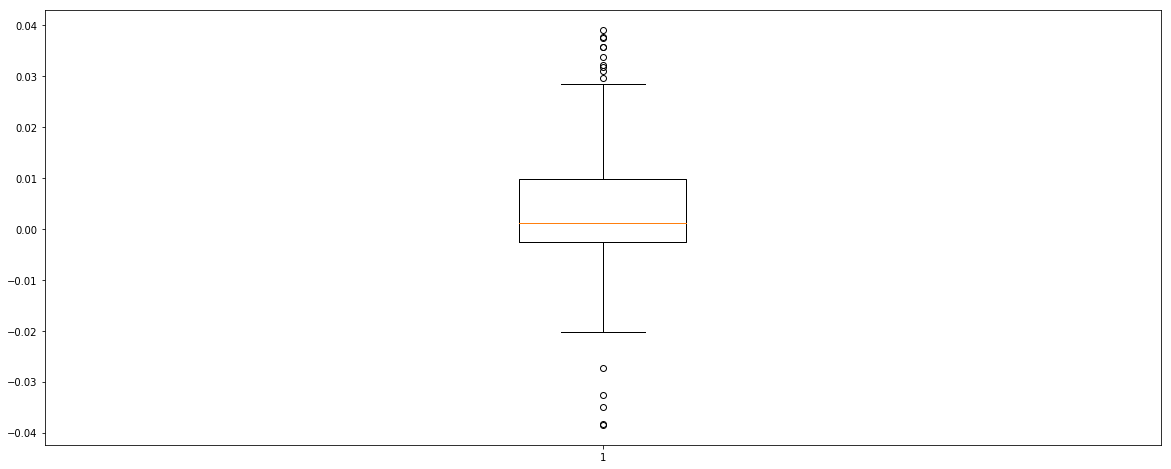

0.0077550923218268723

In [132]:
datadf = np.squeeze(np.asarray(df_sub.values)).ravel()
datadf = datadf[datadf!=0]
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
datadf = reject_outliers(datadf)
plt.figure(figsize=(20,8))
plt.boxplot(datadf)
#plt.hist(datadf,bins=50)
plt.show()
#t.test(np.asmatrix(dfSubtracting))
scipy.stats.ttest_1samp(datadf, 0).pvalue
#scipy.stats.shapiro(datadf)

#scipy.stats.probplot(np.log(abs(datadf)), dist="norm", plot=plt)
#plt.show()
#scipy.stats.kstest(np.log(abs(datadf)), "lognorm", scipy.stats.lognorm.fit(datadf)



# Markov Chain

In [135]:
df_MC_SSP = pd.DataFrame()
for bookname,df in df_Transition_prob.items():
    P = np.matrix(df.as_matrix())
    mc = markovChain(P)
    mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen', 'linear'
    dfSS = pd.DataFrame(list(mc.pi), index=df.index, columns=[bookname])
    df_MC_SSP= pd.concat([dfSS,df_MC_SSP], axis=1)
df_MC_SSP= df_MC_SSP.sort_index(axis=1)
df_MC_SSP = df_MC_SSP.replace(np.nan,0.0)
df_MC_SSP

,1_Chronicles,1_Kings,1_Samuel,2_Chronicles,2_Kings,2_Samuel,Deuteronomy,Esther,Exodus,Ezra,Genesis,Joshua,Judges,Leviticus,Nehemiah,lbh,sbh
Adju,0.038097,0.016898,0.006893,0.033405,0.015293,0.011670,0.022542,0.026750,0.020229,0.043743,0.010065,0.016154,0.010395,0.011711,0.021489,0.032889,0.013200
Clause_Begin,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Clause_End,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Cmpl,0.065444,0.074432,0.081702,0.076341,0.081325,0.085038,0.085503,0.092287,0.067068,0.059801,0.073910,0.093524,0.090282,0.100195,0.073420,0.073422,0.080518
Conj,0.131046,0.138202,0.159268,0.136825,0.148167,0.157366,0.130198,0.124833,0.142565,0.102436,0.154490,0.137877,0.156045,0.141184,0.131236,0.131047,0.149346
Loca,0.006323,0.007644,0.005606,0.008106,0.008001,0.006124,0.009716,0.004904,0.014570,0.009413,0.007155,0.007794,0.006102,0.005205,0.013558,0.008310,0.007723
Modi,0.003794,0.004526,0.004503,0.003474,0.003545,0.005777,0.003498,0.003567,0.006261,0.003876,0.005032,0.005101,0.004181,0.005205,0.004861,0.003802,0.004800
Nega,0.003162,0.005733,0.005055,0.006325,0.007596,0.004391,0.013214,0.004458,0.006623,0.003876,0.002910,0.006943,0.005650,0.000651,0.008698,0.005566,0.005489
Objc,0.051691,0.048179,0.038140,0.059950,0.048410,0.037551,0.061018,0.049487,0.067429,0.054817,0.054872,0.046054,0.045650,0.072219,0.045024,0.054332,0.049414
PreC,0.065602,0.041038,0.030420,0.037680,0.024408,0.028885,0.018655,0.037450,0.030704,0.073643,0.027466,0.041944,0.026893,0.014964,0.054490,0.049706,0.030214


In [134]:
sklearn.metrics.normalized_mutual_info_score(array2,array1)

NameError: name 'array2' is not defined

## Verify MC SSP

We want to verify whether the MC SSP is the same as the normalized frequencies 

In [84]:
length = dict()
for bookname, clauses in data.items():
    length[bookname] = len(clauses) 
df_length = pd.DataFrame(length, index=["Clause_Begin","Clause_End"])
df_new = df_length.append(df_Count)
df_new = df_new.div(df_new.sum(axis=0), axis=1)
df_new= df_new.sort_index(axis=1)
df_new

,1_Chronicles,1_Kings,1_Samuel,2_Chronicles,2_Kings,2_Samuel,Deuteronomy,Esther,Exodus,Ezra,Genesis,Joshua,Judges,Leviticus,Nehemiah,lbh,sbh
Clause_Begin,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Clause_End,0.197597,0.198149,0.193732,0.193123,0.197488,0.192721,0.196658,0.193937,0.192655,0.207087,0.195234,0.192716,0.192655,0.191282,0.201330,0.196550,0.194625
Adju,0.038097,0.016898,0.006893,0.033405,0.015293,0.011670,0.022542,0.026750,0.020229,0.043743,0.010065,0.016154,0.010395,0.011711,0.021489,0.032889,0.013200
Cmpl,0.065444,0.074432,0.081702,0.076341,0.081325,0.085038,0.085503,0.092287,0.067068,0.059801,0.073910,0.093524,0.090282,0.100195,0.073420,0.073422,0.080518
Conj,0.131046,0.138202,0.159268,0.136825,0.148167,0.157366,0.130198,0.124833,0.142565,0.102436,0.154490,0.137877,0.156045,0.141184,0.131236,0.131047,0.149346
Loca,0.006323,0.007644,0.005606,0.008106,0.008001,0.006124,0.009716,0.004904,0.014570,0.009413,0.007155,0.007794,0.006102,0.005205,0.013558,0.008310,0.007723
Modi,0.003794,0.004526,0.004503,0.003474,0.003545,0.005777,0.003498,0.003567,0.006261,0.003876,0.005032,0.005101,0.004181,0.005205,0.004861,0.003802,0.004800
Nega,0.003162,0.005733,0.005055,0.006325,0.007596,0.004391,0.013214,0.004458,0.006623,0.003876,0.002910,0.006943,0.005650,0.000651,0.008698,0.005566,0.005489
Objc,0.051691,0.048179,0.038140,0.059950,0.048410,0.037551,0.061018,0.049487,0.067429,0.054817,0.054872,0.046054,0.045650,0.072219,0.045024,0.054332,0.049414
PreC,0.065602,0.041038,0.030420,0.037680,0.024408,0.028885,0.018655,0.037450,0.030704,0.073643,0.027466,0.041944,0.026893,0.014964,0.054490,0.049706,0.030214


# References

https://journal.r-project.org/archive/2011/RJ-2011-016/RJ-2011-016.pdf